# Project 3: Bouncing Balls

By Maalvika Bhat and Katie Barno

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

# Question: What combination of ball mass and surface material achieve the greatest height on the ball’s first bounce? 

This model can either be interpreted as a prediction model which is going to predict which type of ball will have the longest bounce time or a design model which is going to depict the bouncing behavior of the various kinds of balls. 

The physics of a ball falling and bouncing is relatively well understood and documented. We had learned all of it prior to this project but had to remember to incorporate or purposely ignore all the factors that go into the simple action of a ball bouncing. The ball falls vertically downward under the influence of gravity ('g'). The velocity 'v' points downward. The acceleration 'a' also points downward. The magnitude of 'a' is equal to 'g', in the absence of air resistance. The acceleration due to gravity, 'g', is 9.8 m/s2 on earth. Then, the ball begins to make contact with the surface. It continues to fall vertically downward under the influence of gravity. The velocity and acceleration (equal to 'g' - drag) both continue to point downward. Then, the ball has slowed down. The velocity  is still pointing downward. However, the ball has deformed sufficiently such that the acceleration a is now pointing upward. This means that the ball has deformed enough such that it's pushing against the surface with a force greater than its own weight. We will assume the ball is a spring at this point in our model. As a result, the acceleration a is pointing upward. In the next stage, the ball has reached its maximum deformation. As a result, the acceleration a is still pointing upward, and the velocity is zero. This means that the center is at its lowest point. Then, the balls velocity is increasing and pointing upward, the ball is now in the rebounding stage. As a result, the ball is less deformed than in the previous stage, but is still deformed enough such that it's pushing against the surface with a force greater than its own weight. This means that the acceleration a is still pointing upward. Then, the ball has fully rebounded and has lifted off from the surface. The velocity is still pointing upward, and the acceleration a is still pointing downward since the only force acting on the ball in this stage is gravity. 

![Diagram of Ball Bouncing](diagrams/Cartoon.png)

![Diagram of throwing axe](diagrams/Model.png)


# Model:
We start below by creationg a general state and system for our model.

In [2]:
m = UNITS.meter;
s = UNITS.second;
kg = UNITS.kilogram;

In [3]:
init = State(y = 10, v = 0);

In [4]:
system = System(init = init,
                g = 9.8 * m/s**2,
                mass = 1 * kg,
                diameter = .03 * m,
                k = 1,
                rho = 1,
                C_d = 5,
                t_end = 20 * s);

In [5]:
def drag_force(state, system):
    """Computes drag force in the opposite direction of velocity.
    
    V: velocity
    system: System object with rho, C_d, area
    
    returns: drag force
    """
    unpack(system)
    y, v = state
    
    area = pi * (.5 * diameter)**2
    f_drag = -rho * v**2 * C_d * area / 2
    
    return f_drag

The drag force function (above) takes the state and system and computes drag force in the direction opposite of velocity. It returns the vector drag force. 

In [6]:
def slope_func(state,t,system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    y, v = state
    unpack(system)    
    
    a_drag = (drag_force(state,system))/mass
    dydt = v
    dvdt = -g - a_drag
    
    return dydt, dvdt

The first parameter in the slope function, state, contains the position and velocity of the ball, the second is time. The last parameter, system, contains the system parameters: the acceleration of gravity, mass, diameter, a k value, a rho value, a coefficient of drag, and an end time.
The rest of the function is simply a translation of differential equations. f_drag is force due to drag, based on the drag equation. a_drag is acceleration due to drag, based on Newton’s second law. To compute total acceleration, we add accelerations due to gravity and drag. g is negated because it is in the direction of decreasing y, and a_drag is positive because it is in the direction of increasing y.


In [7]:
def event_func(state, t, system):
    """Return the height of the ball above the ground.
    """
    y, v = state
    return y 

The event function takes an event, the given ball hitting the floor, and ends the simulation. The event function take the same parameters as the slope function, state, t, and system. 

### The First Fall:

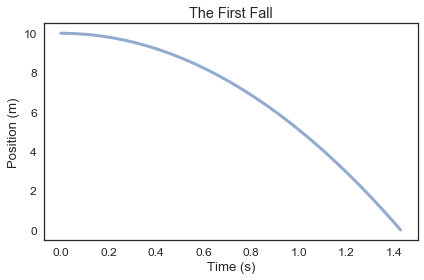

In [8]:
results_1, details = run_ode_solver(system, slope_func, events=event_func, max_step = 0.05*s)
plot(results_1.y)
decorate(title = 'The First Fall',
         xlabel='Time (s)',
         ylabel='Position (m)')

In [9]:
def make_new_system(system, results):
    """Create a new system object
    
    t_0: the final time index of the 'results' TimeFrame
    y, v: the final position and velocity values of the 'results' TimeFrame
    
    returns: updated system object
    """
    t_0 = get_last_label(results)
    y, v = get_last_value(results)
    init = State(y=y, v=v)
    new_system = System(system, t_0=t_0, init=init)
    return new_system

The make_new_system function above takes in a system and a TimeFrame and creates an updated system from the old one by replacing some of the values with the latest values in the TimeFrame.

### The First Bounce:

In [10]:
def up(state,t,system):
    '''Calculates the bounce of the ball after the ground has been hit
    
    y: position
    v: velocity
    PE: initial gravitational potential energy of ball
    a_drag: accelleration due to drag
    a_spring: accelleration on the ball due to the spring
    
    returns: derivatives of y and v
    '''
    unpack(system)
    y,v = state
    
    PE = mass * g * (10)
    deformation = ((2*PE)/k)**.5
    Spring_Force = -k * deformation
    
    a_drag = (drag_force(state,system))/mass
    a_spring = (Spring_Force/mass)
    
    dydt = -v
    dvydt = -(a_spring -g + a_drag)
    
    return dydt,dvydt

In [11]:
def event_func2(state, t, system):
    """Return the velocity of the ball.
    """
    y,v = state
    return v

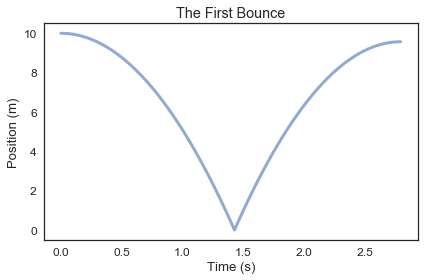

In [12]:
system_up = make_new_system(system, results_1)
results_2, details = run_ode_solver(system_up, up, events=event_func2, max_step = 0.05*s)
total_up = results_1.combine_first(results_2)

plot(total_up.y)
decorate(title = 'The First Bounce',
         xlabel='Time (s)',
         ylabel='Position (m)')

### Falling Back Down


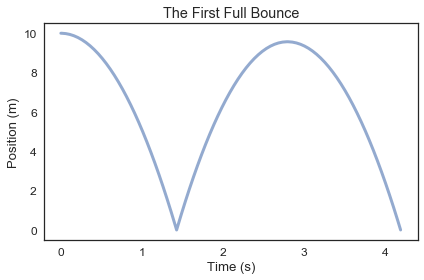

In [13]:
system_down = make_new_system(system_up, results_2);
results_down, details = run_ode_solver(system_down, slope_func, events=event_func, max_step = 0.05*s)
total_down = total_up.combine_first(results_down)

plot(total_down.y)
decorate(title = 'The First Full Bounce',
         xlabel='Time (s)',
         ylabel='Position (m)')

## Adjusting Parameters to Compare Different Balls Bouncing:

We'll start off by condensing our simulation into one function, the one_bounce function below. 

In [14]:
def one_bounce(system, slope_func, up, event_func, event_func2):
    results_a, details = run_ode_solver(system, slope_func, events=event_func, max_step = 0.05*s)
    
    system_Up = make_new_system(system, results_a)
    results_b, details = run_ode_solver(system_Up, up, events=event_func2, max_step = 0.05*s)
    total_Up = results_a.combine_first(results_b)
    
    max_height = get_last_value(results_b.y)
    
    system_Down = make_new_system(system_Up, results_b);
    results_Down, details = run_ode_solver(system_Down, slope_func, events=event_func, max_step = 0.05*s)
    total_Down = total_Up.combine_first(results_Down)
    
    return total_Down, max_height

Beacause we want to know how the mass and surface area influencethe behavior of the ball, we will sweep some of our parameters to see what effect they have on our system. First, we will sweep the diameter of the ball from five centimeters to one meter. 

In [15]:
diameter_array = linspace(.05,1,4);

In [16]:
def diameter_sweep(diameter_array,one_bounce):
    
    for diameter in diameter_array:
        system.diameter = diameter
        results, height = one_bounce(system, slope_func, up, event_func, event_func2)
        print("Diameter = ",diameter*m, "  Maximum Height = ",height*m)
        plot(results.y, label = diameter)
    decorate(title = 'Diameter Sweep',
             xlabel='Time (s)',
             ylabel='Position (m)')
    system.diameter = .03 *m
    return

Next, we will sweep the coefficient of drag for the surface material of our ball. we are expecting this to have as this value increases, the maximum height reached by our ball decreases.

In [17]:
drag_array = linspace(1,10,3);

In [18]:
def drag_sweep(drag_array,one_bounce):
    
    for C_d in drag_array:
        system.C_d = C_d
        result,height = one_bounce(system, slope_func, up, event_func, event_func2)
        print("Drag Coefficient = ",C_d, "  Maximum Height = ",height*m)
        plot(result.y, label = C_d)
    decorate(title = 'Drag Coefficient Sweep',
             xlabel='Time (s)',
             ylabel='Position (m)')
    system.C_d = 1
    return

The last parameter we are sweeping is mass. We expect mass to have the largest effect on our ball's maximum height.

In [19]:
mass_array = linspace(1,10,5);

In [20]:
def mass_sweep(mass_array,one_bounce):
    
    for mass in mass_array:
        system.mass = mass
        result, height = one_bounce(system, slope_func, up, event_func, event_func2)
        print("Mass = ",mass*kg, "  Maximum Height = ",height*m)
        plot(result.y, label = mass)
    decorate(title = 'Mass Sweep',
             xlabel='Time (s)',
             ylabel='Position (m)')
    system.mass = 1*kg
    return

# Results

Diameter =  0.05 meter   Maximum Height =  9.566853187752255 meter
Diameter =  0.36666666666666664 meter   Maximum Height =  9.518601603397162 meter
Diameter =  0.6833333333333333 meter   Maximum Height =  9.399119925010616 meter
Diameter =  1.0 meter   Maximum Height =  9.213632749206917 meter


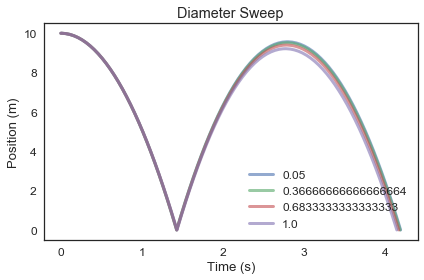

In [21]:
diameter_sweep(diameter_array,one_bounce)

The graph shows that the maximum height decreases as we increase the balls diameter, this is what we expected to find. We did expect the diameter to have a bigger effect on the maximun height reached. 


Drag Coefficient =  1.0   Maximum Height =  9.567705945536224 meter
Drag Coefficient =  5.5   Maximum Height =  9.567408198302752 meter
Drag Coefficient =  10.0   Maximum Height =  9.567110469463893 meter


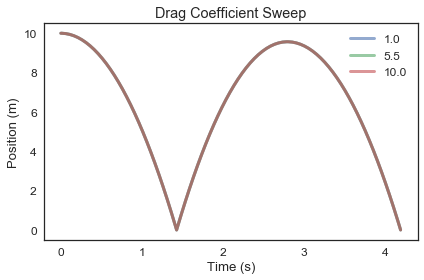

In [22]:
drag_sweep(drag_array,one_bounce)

Again, this parameter sweep shows that this parameter influences the system the way we thought it would, increasing the drag coefficient decreases the maximum height reached, but again, we expected the parameter to have a greater effect on the system. 

Mass =  1.0 kilogram   Maximum Height =  4.097189587937763 meter
Mass =  3.25 kilogram   Maximum Height =  5.569584616372923 meter
Mass =  5.5 kilogram   Maximum Height =  6.208011830653522 meter
Mass =  7.75 kilogram   Maximum Height =  6.6036931463523665 meter
Mass =  10.0 kilogram   Maximum Height =  6.884110452985611 meter


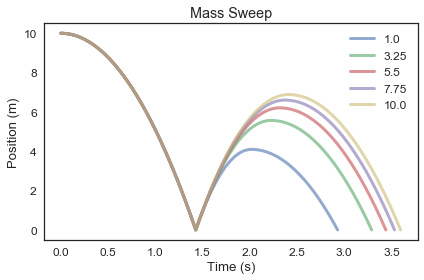

In [23]:
mass_sweep(mass_array,one_bounce)

This graph shows us that increasing the mass of the ball allows it to jump higher. We agree with this result because a more massive object should be able to hold on to more of its momentum. 

Our model clearly predicts that a ball with a small diameter, small drag coefficient and large mass will be the ball that bounces the highest. 

# Interpretation

Our model clearly predicts that a ball with a small diameter, small drag coefficient and large mass will be the ball that bounces the highest. It can be hard to see the results in the diameter and drag coefficient sweep graphs but the mass sweep is very clear. 

We believe several improvements could be made to our model. We only measure the movement of our ball in the vertical dimention, we only measure one bounce, we do not compare the bounces of balls with different spring constants ect. Our model does address our question, we found that the heaviest ball with the smoothest surface will produce the highest bounce. 

We iterated quite a bit throughout this project. We started off with several significant problems and worked our way to a functioning model that answered our question. 